In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/home/ci411/volume_estimation')
import eval_funcs
import model_funcs
import pandas as pd
import torch
from IPython.display import IFrame
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Model prop0_rt60_081922 has completed 1000 epochs
Model prop1_rt60_081922 has completed 1000 epochs
Model prop2_rt60_081922 has completed 1000 epochs
Model prop3_rt60_081922 has completed 1000 epochs
Model prop4_rt60_081922 has completed 1000 epochs
Model prop5_rt60_081922 has completed 1000 epochs
Model prop6_rt60_081922 has completed 1000 epochs
Test Metrics
Validation Metrics
Train Metrics


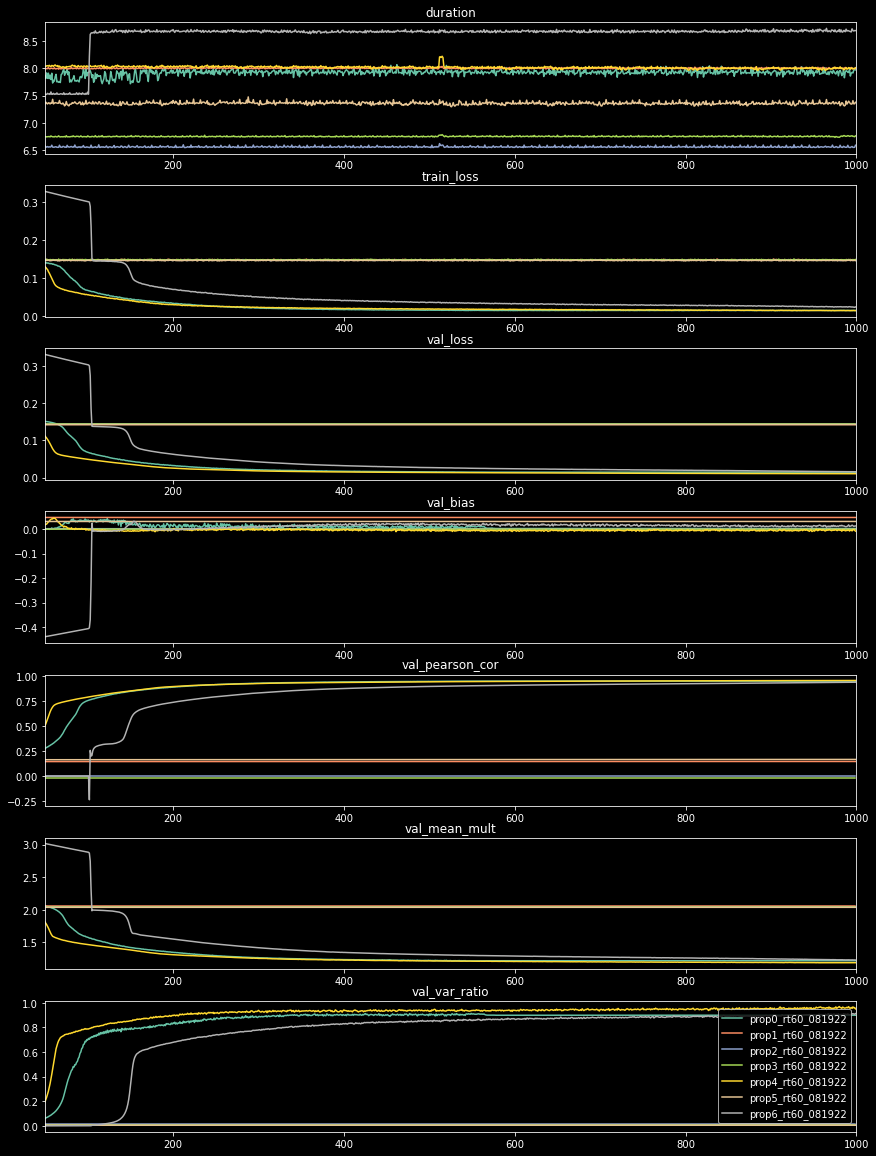

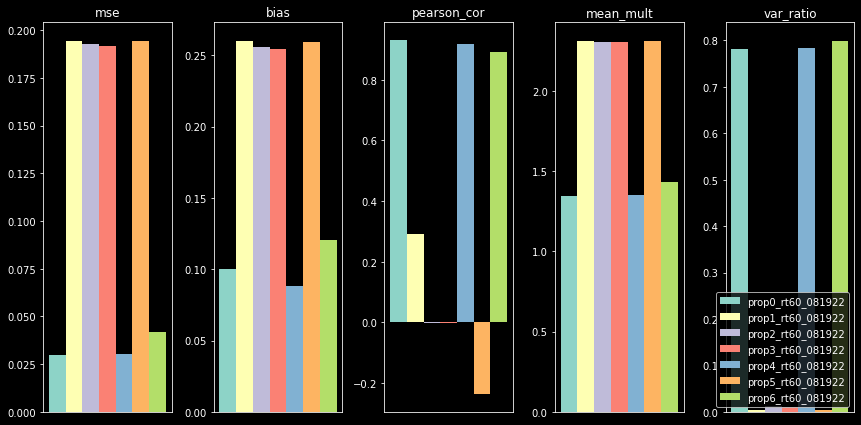

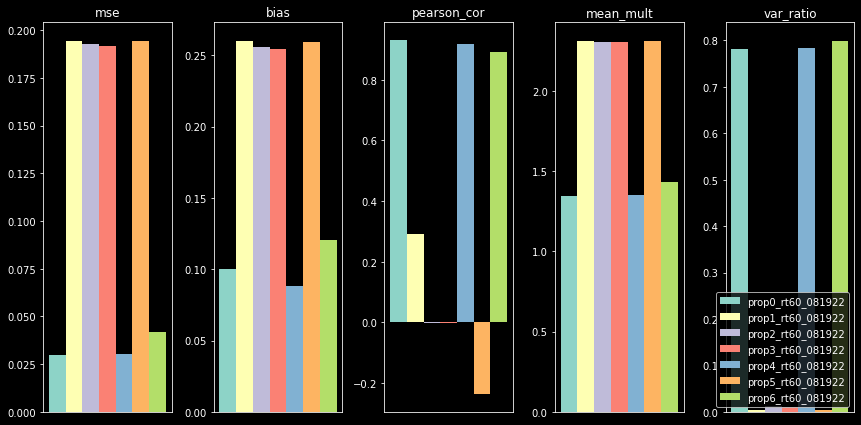

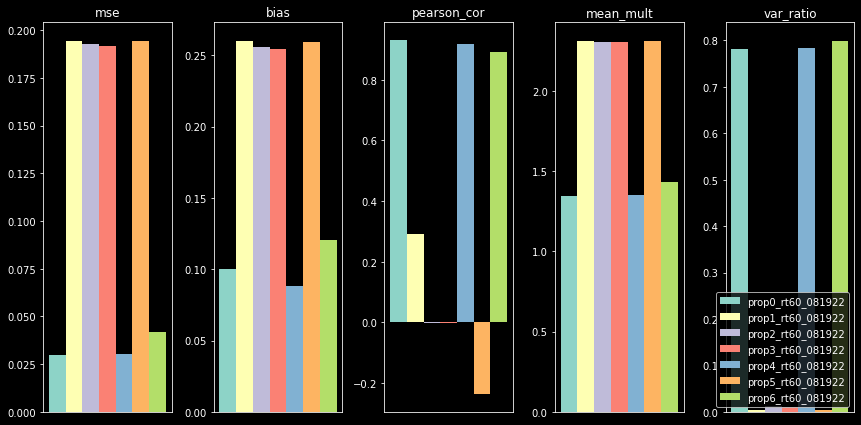

In [22]:
experiment_name = '081922_rt60_comp'
plt.style.use('dark_background')

fig_curves = eval_funcs.plot_experiment_curves(experiment_name, offset=50, cmap='Set2', verbose=True)

print("Test Metrics")
test_metrics = eval_funcs.plot_experiment_metrics(experiment_name, split='test')

print("Validation Metrics")
val_metrics = eval_funcs.plot_experiment_metrics(experiment_name, split='val')

print("Train Metrics")
train_metrics = eval_funcs.plot_experiment_metrics(experiment_name, split='train')


In [21]:
model_name = 'prop0_rt60_081922'
_, model_spec, model_state = eval_funcs.get_model_hist_spec_state(model_name, experiment_name)
feature_df = pd.read_csv(model_spec['data_path'])
test_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='test'].sample(100), log=False, target='rt60')
features, labels = next(iter(test_dataloader))

In [22]:
input_height = features.size()[2]
input_width = features.size()[3]
model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
model.load_state_dict(torch.load(model_state, map_location=device))


<All keys matched successfully>

In [28]:
for (x,y) in test_dataloader:        
    (x, y) = (x.to(device), y.to(device))
    y = y.item()
    pred = model(x).item()
    print(y, 10**pred)

0.9674375 0.8545970235787607
0.40825 0.9522058769034677
4.496666666666667 6.147552566572662
0.93413125 2.406282254586698
0.9674375 1.6742669224802822
0.6588385416666667 1.4241538295782137
2.84175 2.7753606370846677
5.179125 8.443815302861559
0.6588385416666667 1.3575519104992286
2.84175 1.9891574492598472
0.40825 0.8841115730840712
0.40825 2.0504841168612744
0.9674375 0.9526736487554498
2.84175 3.3028110859375865
4.496666666666667 5.370553872485077
1.3517395833333332 2.5489637906617526
0.93413125 0.9112822420529685
0.93413125 1.151973925939959
0.93413125 1.2105087049018108
5.179125 5.122140211514097
0.93413125 1.2504718020689007
0.6588385416666667 1.4171653502631003
0.52271875 0.7152623966865859
1.3517395833333332 3.8031944145271632
4.496666666666667 5.704846618269732
0.9674375 0.953943617370097
1.3517395833333332 1.4180065037048808
5.179125 5.034907089319601
2.84175 2.357708419950934
4.496666666666667 8.100543319972102
0.9674375 1.013441373593737
0.93413125 3.9341368859347967
0.658838

In [18]:
target_sum = 0
pred_sum = 0
n_steps = 0
if verbose:
    print("Computing sums...")
    dataloader_iter = tqdm(dataloader)
else:
    dataloader_iter = dataloader
for (x,y) in dataloader_iter:        
    (x, y) = (x.to(device), y.to(device))
    y = y.item()
    pred = model(x).item()
    target_sum += np.sum(y)
    pred_sum += np.sum(pred)
    n_steps += 1
    del x, y

torch.cuda.empty_cache()

target_mean = target_sum/n_steps
pred_mean = pred_sum/n_steps

mse = 0
mean_error = 0
cov = 0
abs_log_ratio = 0

var_pred = 0 #technically var * N but gets cancelled out in Pearson calculation
var_target = 0 

if verbose:
    print("Computing metrics...")
    dataloader_iter = tqdm(dataloader)
else:
    dataloader_iter = dataloader
for (x,y) in dataloader_iter:          
    (x, y) = (x.to(device), y.to(device))
    pred = model(x)
    mse += MSE(pred, y).item()
    mean_error += Bias(pred, y).item()
    cov += CovStep(pred, y, pred_mean, target_mean).item()
    abs_log_ratio += MeanAbsLogStep(pred, y, log=log).item()

    var_pred += MSE(pred, pred_mean).item()
    var_target += MSE(y, target_mean).item()
    del x, y

out_dict = {}
out_dict['mse'] = (mse / n_steps)
out_dict['bias'] = (mean_error / n_steps)
out_dict['pearson_cor'] = (cov/(np.sqrt(var_pred) * np.sqrt(var_target)))
out_dict['mean_mult'] = (np.exp(abs_log_ratio/n_steps))
out_dict['var_ratio'] = (np.sqrt(var_pred) / np.sqrt(var_target))

return out_dict

IndentationError: unexpected indent (2479630259.py, line 2)

In [ ]:
def evaluate_experiment(experiment_name, model_list=None, log=False, same_features=True, gen_plots=False, target='val'):
    
    if model_list is None:
        model_list = os.listdir(os.path.join(MODELS_DIR, experiment_name))
        model_list.sort()
    
    if same_features:
        _, model_spec, _ = get_model_hist_spec_state(model_list[0], experiment_name)
        feature_df = pd.read_csv(model_spec['data_path'])
        test_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='test'], log=log, target=target)

        features, labels = next(iter(test_dataloader))
        input_height = features.size()[2]
        input_width = features.size()[3]

        model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
    
    for model_name in model_list:
        print("Loading {}".format(model_name))
        _, model_spec, model_state = get_model_hist_spec_state(model_name, experiment_name)
        
        if not same_features:
            print("Loading features from {}".format(model_spec['data_path']))
            feature_df = pd.read_csv(model_spec['data_path'])
            test_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='test'], log=log, target=target)
            features, labels = next(iter(test_dataloader))
            print('labels')
            input_height = features.size()[2]
            input_width = features.size()[3]
            model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
        
        if os.path.exists(model_state):
            model.load_state_dict(torch.load(model_state, map_location=device))
        else:
            print("No weights found for {}".format(model_name))
            continue
        
        print("Computing metrics on {}".format(model_name))
        
        print("Loading test dataloader...")
        test_metrics = compute_eval_metrics(test_dataloader, model, log=log)
        test_path = os.path.join(MODELS_DIR, experiment_name, model_name, 'test_metrics.json')
        print('Saving metrics to {}'.format(test_path))
        with open(test_path, 'w') as f:
            json.dump(test_metrics, f)
        
        print("Loading val dataloader...")
        val_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='val'], log=log, target=target)
        val_metrics = compute_eval_metrics(val_dataloader, model, log=log)
        val_path = os.path.join(MODELS_DIR, experiment_name, model_name, 'val_metrics.json')
        print('Saving metrics to {}'.format(test_path))
        with open(val_path, 'w') as f:
            json.dump(val_metrics, f)   
        
        print("Loading train dataloader...")
        train_dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']=='train'], log=log, target=target)
        train_metrics = compute_eval_metrics(train_dataloader, model, log=log)
        train_path = os.path.join(MODELS_DIR, experiment_name, model_name, 'train_metrics.json')
        print('Saving metrics to {}'.format(train_path))
        with open(train_path, 'w') as f:
            json.dump(train_metrics, f)
            
        
        if gen_plots:
            print("Generating confusion matrices...")
            model_fig_path = os.path.join(FIG_PATH, experiment_name, model_name)
            if not os.path.exists(model_fig_path):
                os.makedirs(model_fig_path)
            _ = generate_confusion_plot(experiment_name, model_name, dataloader=test_dataloader, log=log,\
                                                   verbose=False, savepath=os.path.join(model_fig_path, 'test_cm.pdf'))
            _ = generate_confusion_plot(experiment_name, model_name, split='val', log=log,\
                                                   verbose=False, savepath=os.path.join(model_fig_path, 'val_cm.pdf'))
            _ = generate_confusion_plot(experiment_name, model_name, split='train', log=log,\
                                               verbose=False, savepath=os.path.join(model_fig_path, 'train_cm.pdf'))

    return None